### Virtual Environment Setup

To run this notebook, it's recommended to use a virtual environment. Below are step-by-step instructions to set up and activate the environment:

#### Option 1: Using the setup script (recommended)

We've provided convenience scripts to set up your environment:

**For Windows (PowerShell):**
```powershell
# Run this in PowerShell
.\scripts\setup_environment.ps1
```

**For Linux/macOS:**
```bash
# Run this in Terminal
bash scripts/setup_environment.sh
```

#### Option 2: Manual setup

**1. Create the virtual environment:**
```bash
# Windows (PowerShell)
python -m venv venv

# Linux/macOS
python3 -m venv venv
```

**2. Activate the virtual environment:**
```bash
# Windows (PowerShell)
.\venv\Scripts\Activate.ps1

# Windows (Command Prompt)
.\venv\Scripts\activate.bat

# Linux/macOS
source venv/bin/activate
```

**3. Install required packages:**
```bash
pip install -r requirements.txt
```

**4. Download additional resources:**
```bash
python -m spacy download en_core_web_sm
```

**5. Register the environment with Jupyter (if needed):**
```bash
python -m ipykernel install --user --name=nlp-topic-modeling --display-name="Python (NLP Topic Modeling)"
```

**6. Launch Jupyter Notebook and select the kernel:**
```bash
jupyter notebook
```

> **Note:** After setting up the environment, make sure to select the correct kernel in Jupyter (Python (NLP Topic Modeling))

# 🔍 NLP-Based Topic Modeling Pipeline

This notebook implements a comprehensive topic modeling pipeline on unstructured citizen complaint data from the U.S. Consumer Financial Protection Bureau. We'll extract dominant themes using a combination of classical and semantic NLP methods including TF-IDF, Word2Vec, LDA, and NMF.

## Pipeline Overview

1. Environment Setup
2. Data Ingestion
3. Data Cleaning & Text Preprocessing
4. Exploratory Analysis
5. Text Vectorization (TF-IDF and Word2Vec)
6. Topic Modeling (LDA and NMF)
7. Interpretation and Discussion
8. Export and Version Control

## 1. Environment Setup

First, we'll set up a clean virtual environment and install all necessary dependencies for our NLP pipeline.

### Benefits of Using a Virtual Environment:

- **Isolation**: Keeps project dependencies separate from your system Python installation
- **Reproducibility**: Makes it easier to recreate the exact same environment on different machines
- **Dependency Management**: Prevents conflicts between package versions across different projects
- **Clean Environment**: Ensures only the packages needed for this project are installed
- **Version Control**: The requirements.txt file allows tracking of exact package versions

We'll use Python's built-in `venv` module to create our virtual environment.

In [ ]:
# Setting up a virtual environment (best practice)

'''
# Create a virtual environment
# Run these commands in your terminal

# For Windows PowerShell
python -m venv venv                    # Create virtual environment named 'venv'
.\venv\Scripts\Activate.ps1           # Activate the virtual environment

# For Windows Command Prompt
# python -m venv venv
# .\venv\Scripts\activate.bat

# For macOS/Linux
# python -m venv venv
# source venv/bin/activate

# Install required packages from requirements.txt
pip install -r requirements.txt

# Or install packages individually
pip install pandas numpy matplotlib seaborn nltk spacy gensim scikit-learn pyLDAvis tqdm wordcloud
python -m spacy download en_core_web_sm
'''

In [1]:
# Note: Make sure you're running this notebook within your virtual environment
# You can verify this by checking sys.prefix
import sys
print(f"Python interpreter: {sys.executable}")
print(f"Python environment: {sys.prefix}")

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import os
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
import spacy
from gensim import corpora, models
from gensim.models import Word2Vec, LdaModel
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.gensim_models
from wordcloud import WordCloud
from tqdm import tqdm

# Create directories for outputs
output_dirs = ['data', 'results', 'results/visualizations', 'results/models']
for dir_path in output_dirs:
    os.makedirs(dir_path, exist_ok=True)

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

Python interpreter: c:\Users\HP\anaconda3\envs\ai_env\python.exe
Python environment: c:\Users\HP\anaconda3\envs\ai_env


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...


True

In [2]:
# Create requirements.txt file
with open('requirements.txt', 'w') as f:
    f.write('''pandas==2.0.0
numpy==1.24.3
matplotlib==3.7.1
seaborn==0.12.2
nltk==3.8.1
spacy==3.7.2
gensim==4.3.1
scikit-learn==1.3.0
pyLDAvis==3.4.1
tqdm==4.65.0
wordcloud==1.9.2
''')

print("Requirements file created successfully!")

Requirements file created successfully!


In [4]:
## 2. Data Ingestion

"We'll load the consumer complaints dataset and focus on the narrative column."

# Check if running in virtual environment
import sys
import os

def is_virtual_env():
    # Based on the base_prefix or real_prefix vs. prefix check
    return (hasattr(sys, 'base_prefix') and sys.base_prefix != sys.prefix) or \
           (hasattr(sys, 'real_prefix') and sys.real_prefix != sys.prefix)

if is_virtual_env():
    print("✅ Running in a virtual environment: ", sys.prefix)
else:
    print("⚠️ WARNING: Not running in a virtual environment!")
    print("It's recommended to use a virtual environment for this project.")
    print("See the 'Virtual Environment Setup' section above for instructions.")

# Create requirements.txt file
with open('requirements.txt', 'w') as f:
    f.write('''pandas==2.0.0
numpy==1.24.3
matplotlib==3.7.1
seaborn==0.12.2
nltk==3.8.1
spacy==3.7.2
gensim==4.3.1
scikit-learn==1.3.0
pyLDAvis==3.4.1
tqdm==4.65.0
wordcloud==1.9.2
jupyter==1.0.0
ipykernel==6.25.0
''')

print("\nRequirements file created successfully!")

# List installed packages for comparison
import pkg_resources
installed_packages = {pkg.key: pkg.version for pkg in pkg_resources.working_set}
print("\nCurrently installed packages:")
required_packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'nltk', 'spacy', 
                    'gensim', 'scikit-learn', 'pyldavis', 'tqdm', 'wordcloud']
for package in required_packages:
    status = "✓" if package in installed_packages else "✗"
    version = installed_packages.get(package, "Not installed")
    print(f"  {status} {package}: {version}")

⚠️ WARNING: Not running in a virtual environment!
It's recommended to use a virtual environment for this project.
See the 'Virtual Environment Setup' section above for instructions.

Requirements file created successfully!

Currently installed packages:
  ✓ pandas: 2.2.3
  ✓ numpy: 1.26.4
  ✓ matplotlib: 3.10.0
  ✓ seaborn: 0.13.2
  ✓ nltk: 3.9.1
  ✓ spacy: 3.7.2
  ✓ gensim: 4.3.3
  ✓ scikit-learn: 1.6.1
  ✓ pyldavis: 3.4.1
  ✓ tqdm: 4.67.1
  ✓ wordcloud: 1.9.4

Currently installed packages:
  ✓ pandas: 2.2.3
  ✓ numpy: 1.26.4
  ✓ matplotlib: 3.10.0
  ✓ seaborn: 0.13.2
  ✓ nltk: 3.9.1
  ✓ spacy: 3.7.2
  ✓ gensim: 4.3.3
  ✓ scikit-learn: 1.6.1
  ✓ pyldavis: 3.4.1
  ✓ tqdm: 4.67.1
  ✓ wordcloud: 1.9.4


C:\Users\HP\AppData\Local\Temp\ipykernel_23808\3659446551.py:41: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [6]:
# Load the consumer complaints dataset
df = pd.read_csv('consumer_complaints.csv', low_memory=False)

# Display the dataset info
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

# Check for the complaint narrative column
narrative_col = 'consumer_complaint_narrative'
if narrative_col in df.columns:
    print(f"\nFound narrative column: {narrative_col}")
    
    # Display a sample of the narrative data
    print("\nSample complaints:")
    sample_narratives = df[narrative_col].dropna().sample(3).tolist()
    for i, narrative in enumerate(sample_narratives):
        print(f"\nSample {i+1}: {narrative[:200]}...")
else:
    # If the column name is different, find it
    possible_cols = [col for col in df.columns if 'narrative' in col.lower() or 'complaint' in col.lower()]
    if possible_cols:
        narrative_col = possible_cols[0]
        print(f"\nUsing alternative narrative column: {narrative_col}")
    else:
        raise ValueError("Could not find a column containing complaint narratives")

Dataset shape: (555957, 18)

Columns: ['date_received', 'product', 'sub_product', 'issue', 'sub_issue', 'consumer_complaint_narrative', 'company_public_response', 'company', 'state', 'zipcode', 'tags', 'consumer_consent_provided', 'submitted_via', 'date_sent_to_company', 'company_response_to_consumer', 'timely_response', 'consumer_disputed?', 'complaint_id']

Found narrative column: consumer_complaint_narrative

Sample complaints:

Sample 1: On XXXX XXXX of 2015 I requested my Experian credit file frozen. 
I was told I would get a PIN # in the mail, but it never came. 
I am looking to refinance a mortgage now, but without the PIN I can no...

Sample 2: I am contacting you in reference to a matter that I 've had to send communications to Capital One about. Everyother month Capital One XXXX reporting my auto loan on my credit report, I dispute it, it ...

Sample 3: Chase Mortgage has refused my request for mortgage assistance. I have repeatedly requested a modification. Since Chase recei

In [7]:
# Filter out rows with empty narratives
df_filtered = df.dropna(subset=[narrative_col])

# Calculate how many rows were removed
removed_rows = df.shape[0] - df_filtered.shape[0]
print(f"\nRemoved {removed_rows} rows with missing narratives ({removed_rows/df.shape[0]:.2%} of total)")
print(f"Remaining dataset shape: {df_filtered.shape}")

# Take a subset of the data for faster processing (adjust based on your computational resources)
subset_size = min(50000, df_filtered.shape[0])  # Limit to 50,000 complaints for processing efficiency
df_subset = df_filtered.sample(subset_size, random_state=42) if df_filtered.shape[0] > subset_size else df_filtered

print(f"\nUsing {df_subset.shape[0]} complaints for analysis")


Removed 489151 rows with missing narratives (87.98% of total)
Remaining dataset shape: (66806, 18)

Using 50000 complaints for analysis


## 3. Data Cleaning & Text Preprocessing

We'll clean and preprocess the text data through the following steps:

1. Lowercase all text
2. Remove punctuation, numbers, and special characters
3. Tokenize the text
4. Remove English stopwords
5. Lemmatize tokens
6. Remove single-character tokens and excessive whitespace

In [10]:
# Load spaCy model for lemmatization
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Get English stopwords
stop_words = set(stopwords.words('english'))

# Additional domain-specific terms to remove
domain_stops = {'xxxx', 'xx', 'xxx', 'x', 'xx/xx/xxxx'}
stop_words.update(domain_stops)

def clean_text(text):
    """Clean the text by removing punctuation, numbers, and special characters"""
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove numbers, punctuation, and special characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special characters
    text = re.sub(r'\s+', ' ', text)  # Remove excessive whitespace
    
    return text.strip()

def lemmatize_text(text):
    """Tokenize, remove stopwords, and lemmatize text using spaCy"""
    if not text:
        return []
    
    # Process with spaCy
    doc = nlp(text)
    
    # Lemmatize and filter tokens
    tokens = [token.lemma_ for token in doc 
              if token.lemma_.lower() not in stop_words 
              and len(token.lemma_) > 1  # Remove single-character tokens
              and not token.is_punct 
              and not token.is_space
              and not token.like_num]  # Remove numbers (backup)
    
    return tokens

def preprocess_pipeline(text):
    """Complete preprocessing pipeline"""
    # Clean the text
    cleaned_text = clean_text(text)
    
    # Tokenize, remove stopwords, and lemmatize
    processed_tokens = lemmatize_text(cleaned_text)
    
    return processed_tokens

In [11]:
from tqdm import tqdm
# Apply preprocessing to the narratives
print("Preprocessing complaint narratives...")

# Process a sample first to verify the pipeline
sample_text = df_subset[narrative_col].iloc[0]
print(f"\nOriginal text:\n{sample_text[:500]}...")

cleaned_sample = clean_text(sample_text)
print(f"\nAfter cleaning:\n{cleaned_sample[:500]}...")

lemmatized_sample = lemmatize_text(cleaned_sample)
print(f"\nAfter lemmatization:\n{' '.join(lemmatized_sample[:50])}...")

# Apply preprocessing to all narratives with progress bar
tqdm.pandas(desc="Processing complaints")
df_subset['cleaned_text'] = df_subset[narrative_col].progress_apply(clean_text)
df_subset['tokens'] = df_subset['cleaned_text'].progress_apply(lemmatize_text)

# Filter out documents with very few tokens (likely not meaningful)
min_tokens = 5
df_processed = df_subset[df_subset['tokens'].apply(len) >= min_tokens].reset_index(drop=True)
print(f"\nRemoved {df_subset.shape[0] - df_processed.shape[0]} documents with fewer than {min_tokens} tokens")
print(f"Final dataset shape: {df_processed.shape}")

# Create a joined version of tokens for some models
df_processed['processed_text'] = df_processed['tokens'].apply(lambda x: ' '.join(x))

# Save a preview of the cleaned dataset
df_preview = df_processed[['processed_text', 'tokens']].head(10)
df_preview.to_csv('data/cleaned_data_preview.csv', index=False)
print("\nSaved cleaned data preview to 'data/cleaned_data_preview.csv'")

Preprocessing complaint narratives...

Original text:
I have been battling with portfolio recovery and Foster, Garbus & Garbus for over a year regarding a debt that is not mine. I continue receiving letters from Foster, Garbus XXXX Garbus regarding same debt although I 've submitted documents to Foster, Garbus & Garbus proving that I DO NOT OWE said debt. These guys went as far as having my XXXX XXXX account frozen last year and I thought the issue was resolved once I submitted my documents. 
...

After cleaning:
i have been battling with portfolio recovery and foster garbus garbus for over a year regarding a debt that is not mine i continue receiving letters from foster garbus xxxx garbus regarding same debt although i ve submitted documents to foster garbus garbus proving that i do not owe said debt these guys went as far as having my xxxx xxxx account frozen last year and i thought the issue was resolved once i submitted my documents...

After lemmatization:
battle portfolio recover

Processing complaints:   0%|          | 0/50000 [00:00<?, ?it/s]

Processing complaints: 100%|██████████| 50000/50000 [12:59<00:00, 64.16it/s] 




Removed 392 documents with fewer than 5 tokens
Final dataset shape: (49608, 20)

Saved cleaned data preview to 'data/cleaned_data_preview.csv'


## 4. Exploratory Analysis

We'll explore and visualize the preprocessed data to better understand the content of the complaints.

Number of complaints: 49608

Token count statistics:
  - Average tokens per complaint: 82.56
  - Median tokens per complaint: 59.00
  - Min tokens: 5
  - Max tokens: 381


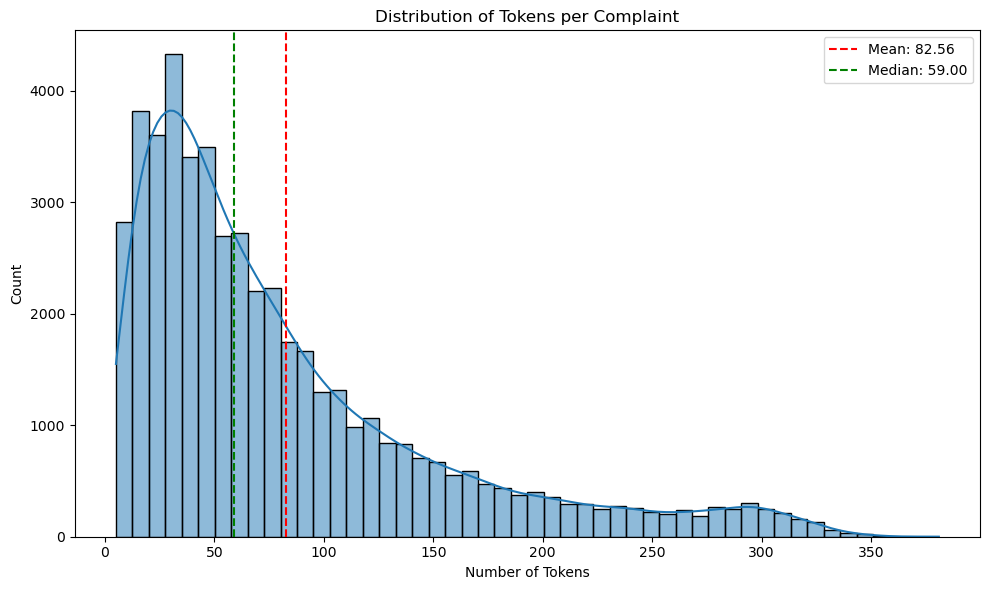

In [12]:
# Basic statistics about the dataset
print(f"Number of complaints: {df_processed.shape[0]}")

# Calculate and display token counts
token_counts = df_processed['tokens'].apply(len)
print(f"\nToken count statistics:")
print(f"  - Average tokens per complaint: {token_counts.mean():.2f}")
print(f"  - Median tokens per complaint: {token_counts.median():.2f}")
print(f"  - Min tokens: {token_counts.min()}")
print(f"  - Max tokens: {token_counts.max()}")

# Plot distribution of tokens per document
plt.figure(figsize=(10, 6))
sns.histplot(token_counts, bins=50, kde=True)
plt.title('Distribution of Tokens per Complaint')
plt.xlabel('Number of Tokens')
plt.ylabel('Count')
plt.axvline(x=token_counts.mean(), color='red', linestyle='--', label=f'Mean: {token_counts.mean():.2f}')
plt.axvline(x=token_counts.median(), color='green', linestyle='--', label=f'Median: {token_counts.median():.2f}')
plt.legend()
plt.tight_layout()
plt.savefig('results/visualizations/token_distribution.png')
plt.show()


Top 20 most frequent tokens:
credit      66273
account     63306
call        53468
payment     50785
pay         42293
loan        40851
report      39387
would       35833
tell        33765
bank        33678
receive     32220
xxxxxxxx    32063
make        30483
time        30419
get         29400
debt        27554
send        27374
say         25948
card        24578
company     23966
Name: count, dtype: int64


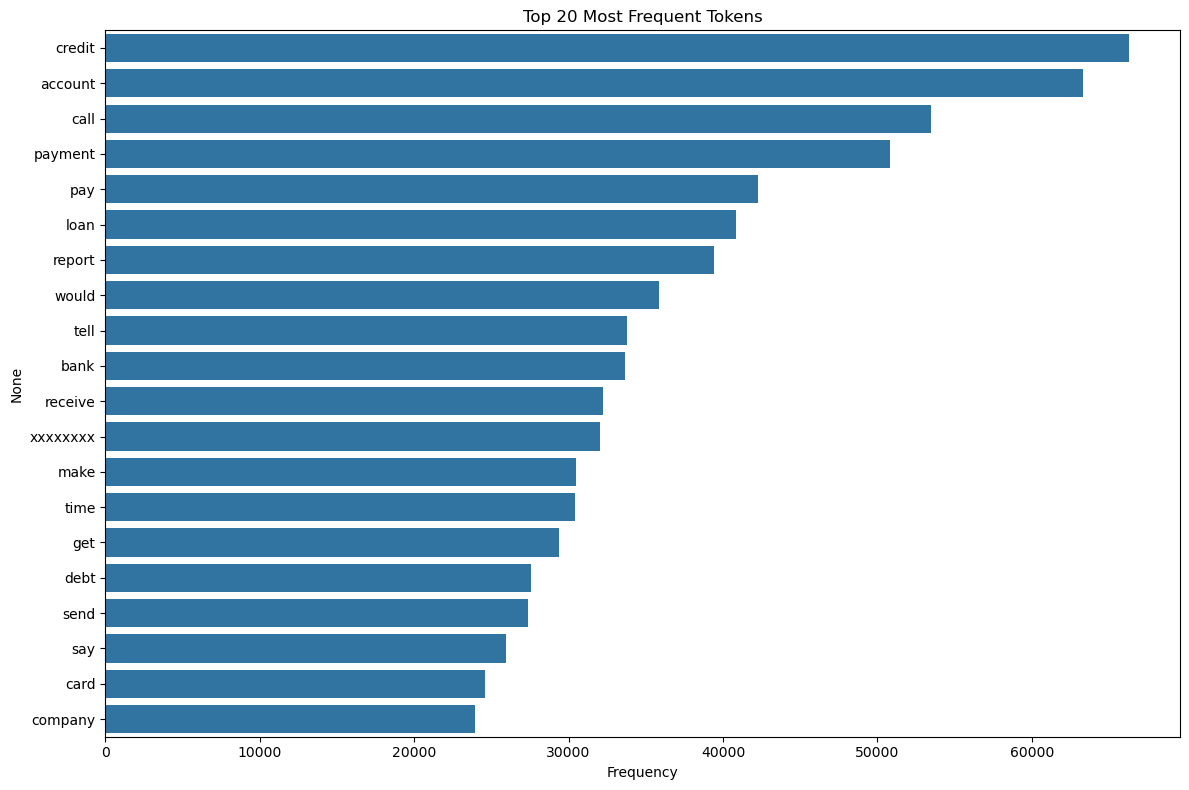

In [13]:
# Calculate most frequent tokens
all_tokens = [token for doc in df_processed['tokens'] for token in doc]
token_freq = pd.Series(all_tokens).value_counts()

# Display top tokens
top_n = 20
print(f"\nTop {top_n} most frequent tokens:")
print(token_freq.head(top_n))

# Plot top tokens
plt.figure(figsize=(12, 8))
sns.barplot(x=token_freq.head(top_n).values, y=token_freq.head(top_n).index)
plt.title(f'Top {top_n} Most Frequent Tokens')
plt.xlabel('Frequency')
plt.tight_layout()
plt.savefig('results/visualizations/top_tokens.png')
plt.show()


Top 20 most frequent bi-grams:
(credit, report)        17213
(credit, card)          10919
(make, payment)          6272
(wells, fargo)           6255
(bank, america)          5218
(collection, agency)     4415
(customer, service)      4340
(phone, call)            4117
(call, back)             3943
(credit, reporting)      3438
(credit, score)          3404
(late, fee)              3330
(loan, modification)     3284
(receive, letter)        3014
(interest, rate)         2960
(even, though)           2954
(would, like)            2815
(send, letter)           2738
(credit, bureaus)        2695
(report, credit)         2656
Name: count, dtype: int64


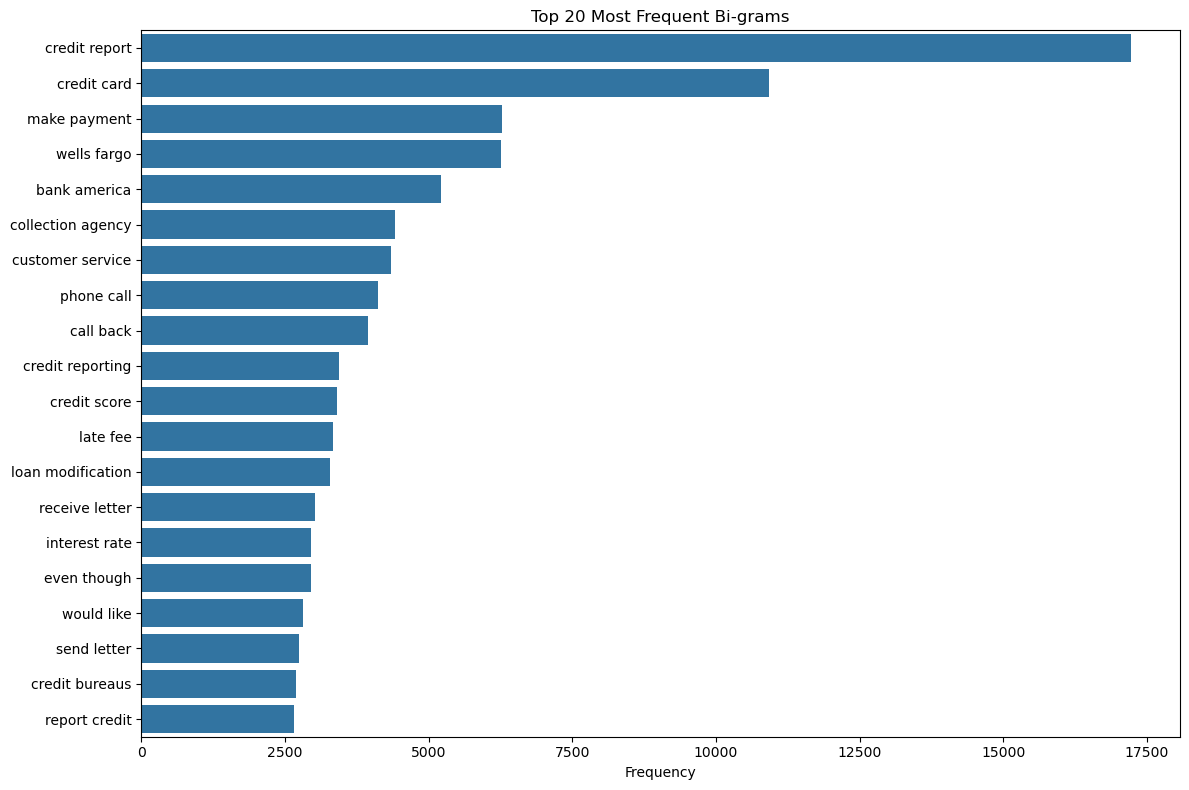


Top 20 most frequent tri-grams:
(credit, reporting, agency)       1607
(social, security, number)        1180
(remove, credit, report)           999
(fair, credit, reporting)          978
(credit, reporting, act)           961
(credit, card, account)            894
(credit, card, company)            876
(information, credit, report)      736
(account, credit, report)          707
(report, credit, report)           684
(charge, late, fee)                676
(receive, phone, call)             675
(debt, collection, practice)       672
(fair, debt, collection)           665
(attempt, collect, debt)           661
(call, customer, service)          624
(xxxxxxxx, xxxxxxxx, xxxxxxxx)     611
(victim, identity, theft)          603
(collection, practice, act)        582
(wells, fargo, bank)               572
Name: count, dtype: int64


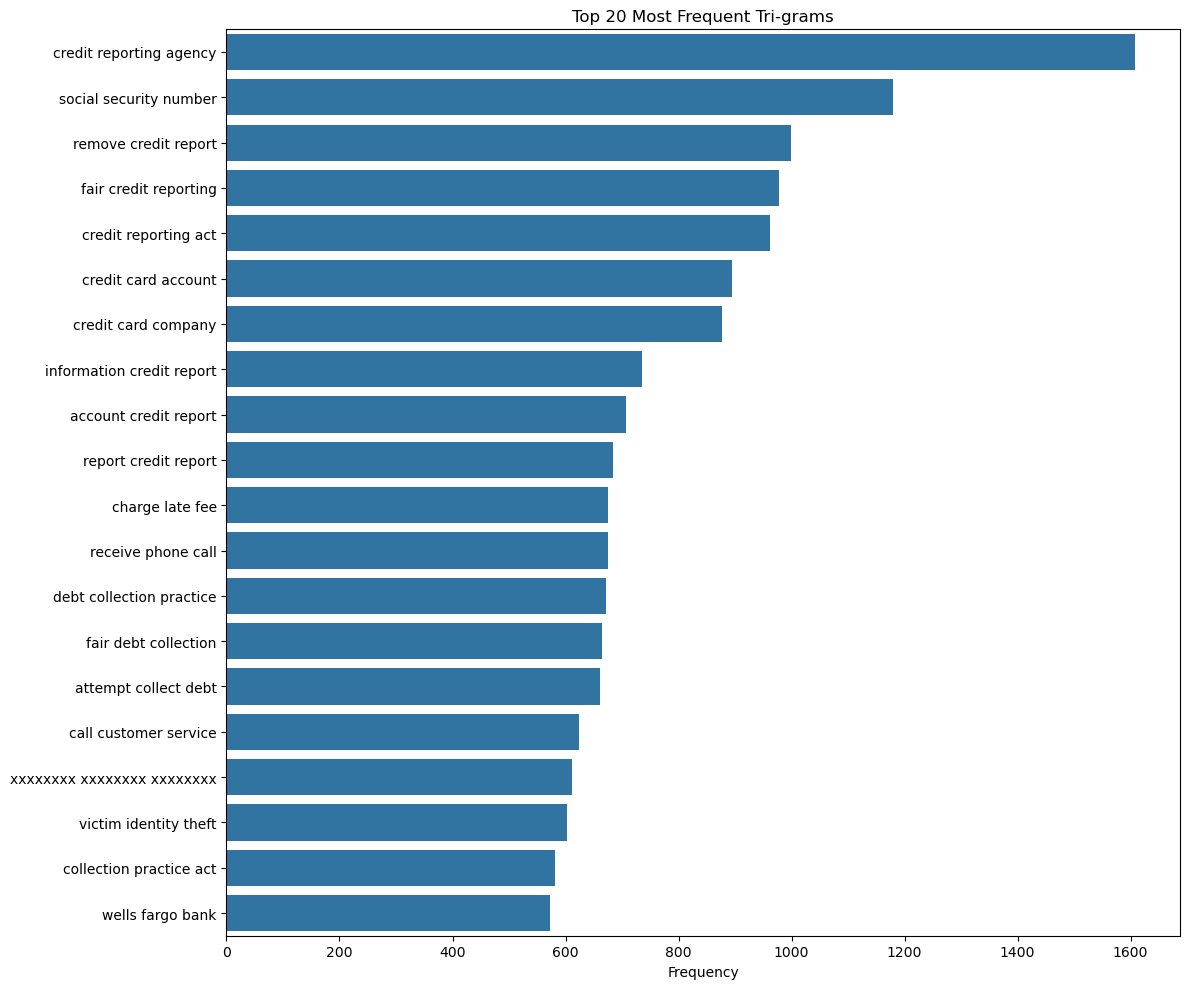

In [14]:
# Function to generate n-grams
def get_ngrams(tokens_list, n=2):
    """Generate n-grams from list of tokens"""
    all_ngrams = []
    for tokens in tokens_list:
        all_ngrams.extend(list(ngrams(tokens, n)))
    return all_ngrams

# Generate and visualize bi-grams
bigrams = get_ngrams(df_processed['tokens'], n=2)
bigram_freq = pd.Series(bigrams).value_counts()

print(f"\nTop {top_n} most frequent bi-grams:")
print(bigram_freq.head(top_n))

# Plot top bi-grams
plt.figure(figsize=(12, 8))
top_bigrams = bigram_freq.head(top_n)
sns.barplot(x=top_bigrams.values, 
            y=[' '.join(bg) for bg in top_bigrams.index])
plt.title(f'Top {top_n} Most Frequent Bi-grams')
plt.xlabel('Frequency')
plt.tight_layout()
plt.savefig('results/visualizations/top_bigrams.png')
plt.show()

# Generate and visualize tri-grams
trigrams = get_ngrams(df_processed['tokens'], n=3)
trigram_freq = pd.Series(trigrams).value_counts()

print(f"\nTop {top_n} most frequent tri-grams:")
print(trigram_freq.head(top_n))

# Plot top tri-grams
plt.figure(figsize=(12, 10))
top_trigrams = trigram_freq.head(top_n)
sns.barplot(x=top_trigrams.values, 
            y=[' '.join(tg) for tg in top_trigrams.index])
plt.title(f'Top {top_n} Most Frequent Tri-grams')
plt.xlabel('Frequency')
plt.tight_layout()
plt.savefig('results/visualizations/top_trigrams.png')
plt.show()

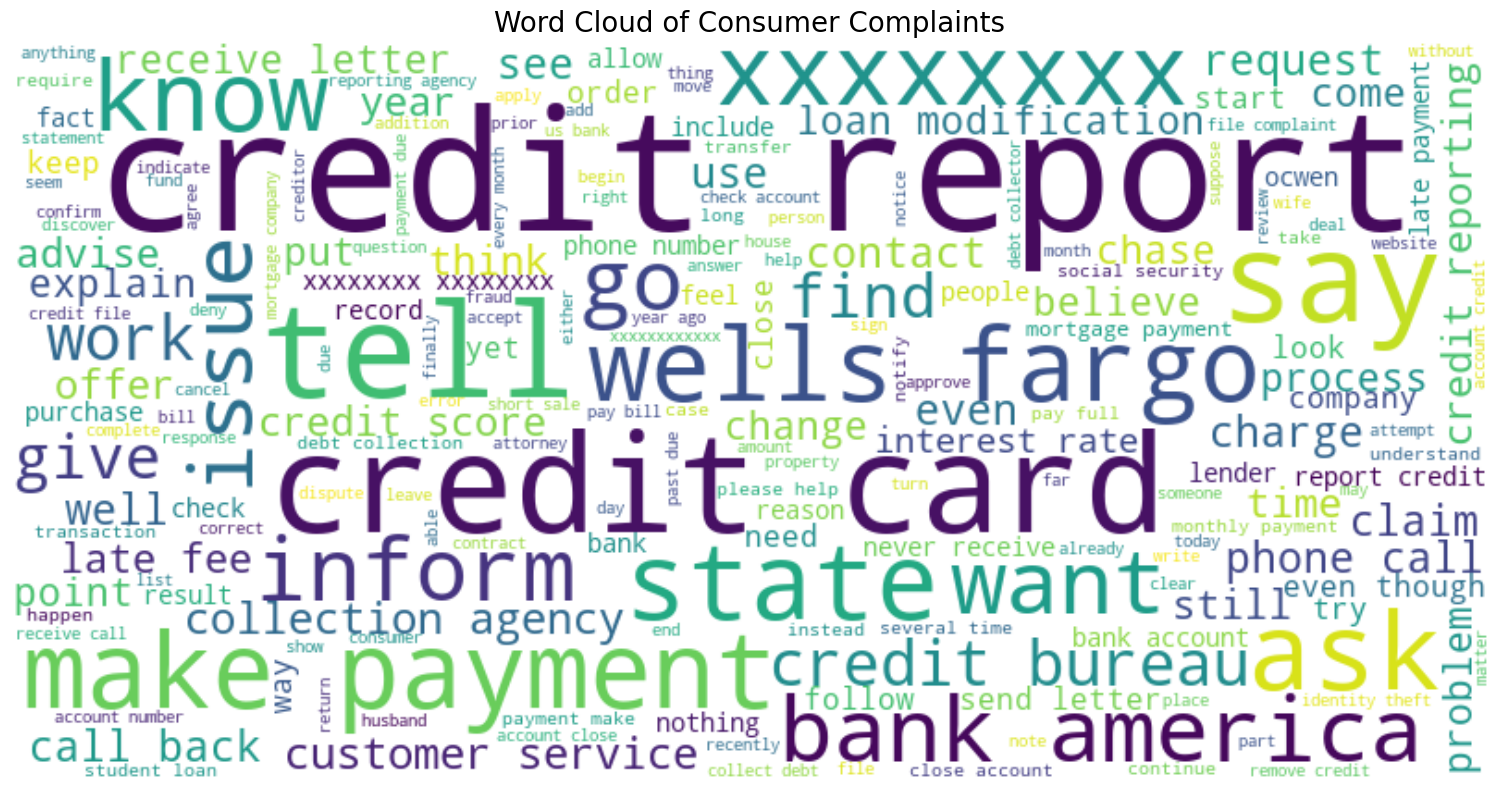

In [15]:
from wordcloud import WordCloud
# Create a word cloud of all terms
all_text = ' '.join(df_processed['processed_text'])

wordcloud = WordCloud(width=800, height=400, 
                     background_color='white',
                     max_words=200,
                     contour_width=3,
                     contour_color='steelblue',
                     colormap='viridis').generate(all_text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Consumer Complaints', fontsize=20)
plt.tight_layout()
plt.savefig('results/visualizations/wordcloud.png')
plt.show()

## 5. Text Vectorization

### 5.1 TF-IDF Vectorization

We'll use TF-IDF (Term Frequency-Inverse Document Frequency) to convert our preprocessed text into a numerical format.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# Initialize TF-IDF vectorizer with specified parameters
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95,  # Ignore terms that appear in more than 95% of documents
    min_df=10,    # Ignore terms that appear in fewer than 10 documents
    max_features=1000,  # Only consider the top 1000 features
    ngram_range=(1, 2)  # Include both unigrams and bigrams
)

# Fit and transform the processed text
tfidf_matrix = tfidf_vectorizer.fit_transform(df_processed['processed_text'])

# Get feature names (terms)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Number of features (terms): {len(tfidf_feature_names)}")

# Display some of the feature names
print("\nSample of features (terms):")
print(tfidf_feature_names[:20])

# Show a sample of the TF-IDF matrix
print("\nSample of TF-IDF vectors (first 2 documents, first 10 features):")
tfidf_sample = pd.DataFrame(
    tfidf_matrix[:2, :10].toarray(), 
    columns=tfidf_feature_names[:10]
)
print(tfidf_sample)

# Save the TF-IDF vectorizer and matrix for later use
with open('results/models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
    
with open('results/models/tfidf_matrix.pkl', 'wb') as f:
    pickle.dump(tfidf_matrix, f)
    
print("\nTF-IDF vectorizer and matrix saved to disk")

TF-IDF matrix shape: (49608, 1000)
Number of features (terms): 1000

Sample of features (terms):
['ability' 'able' 'accept' 'access' 'accord' 'account' 'account account'
 'account close' 'account credit' 'account number' 'account open'
 'account pay' 'account report' 'account would' 'acct' 'accurate'
 'acknowledge' 'act' 'action' 'activity']

Sample of TF-IDF vectors (first 2 documents, first 10 features):
   ability      able  accept  access    accord  account  account account  \
0      0.0  0.000000     0.0     0.0  0.000000  0.08496              0.0   
1      0.0  0.039193     0.0     0.0  0.051202  0.00000              0.0   

   account close  account credit  account number  
0            0.0             0.0             0.0  
1            0.0             0.0             0.0  

TF-IDF vectorizer and matrix saved to disk


### 5.2 Word2Vec Vectorization

Next, we'll use Word2Vec to create dense vector representations of our documents.

In [17]:
import gensim
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

# Initialize and train Word2Vec model
print("Training Word2Vec model...")
w2v_model = Word2Vec(
    sentences=df_processed['tokens'],
    vector_size=100,  # Dimension of the word vectors
    window=5,         # Context window size
    min_count=5,      # Minimum word frequency
    workers=4,        # Number of threads to use
    sg=1,             # Skip-gram model (1) vs CBOW (0)
    epochs=10,        # Number of training epochs
    seed=42           # For reproducibility
)

print(f"Word2Vec model trained with {len(w2v_model.wv.index_to_key)} words")

# Create document vectors by averaging word vectors
def document_vector(word2vec_model, doc):
    """Create a document vector by averaging word vectors"""
    # Filter out words not in vocabulary
    doc_words = [word for word in doc if word in word2vec_model.wv.index_to_key]
    if not doc_words:
        # Return zeros if no words are in vocabulary
        return np.zeros(word2vec_model.wv.vector_size)
    
    # Average the word vectors
    return np.mean(word2vec_model.wv[doc_words], axis=0)

# Generate document vectors
print("Generating document vectors...")
doc_vectors = np.array([document_vector(w2v_model, doc) for doc in tqdm(df_processed['tokens'])])

print(f"\nDocument vectors shape: {doc_vectors.shape}")

# Display a sample of the document vectors
print("\nSample of document vectors (first 2 documents, first 10 dimensions):")
w2v_sample = pd.DataFrame(
    doc_vectors[:2, :10],
    columns=[f'dim_{i}' for i in range(10)]
)
print(w2v_sample)

# Save the Word2Vec model and document vectors
w2v_model.save('results/models/word2vec_model.model')
with open('results/models/doc_vectors.pkl', 'wb') as f:
    pickle.dump(doc_vectors, f)
    
print("\nWord2Vec model and document vectors saved to disk")

Training Word2Vec model...
Word2Vec model trained with 10626 words
Generating document vectors...
Word2Vec model trained with 10626 words
Generating document vectors...


100%|██████████| 49608/49608 [00:43<00:00, 1145.44it/s]


Document vectors shape: (49608, 100)

Sample of document vectors (first 2 documents, first 10 dimensions):
      dim_0     dim_1     dim_2     dim_3     dim_4     dim_5     dim_6  \
0  0.062065 -0.159310 -0.191106 -0.129985 -0.110252  0.084544  0.276213   
1  0.116476 -0.041556 -0.169192  0.028472 -0.027966  0.063470  0.111489   

      dim_7     dim_8     dim_9  
0  0.162485  0.056953  0.093103  
1 -0.028071  0.021856 -0.036275  

Word2Vec model and document vectors saved to disk


In [18]:
# Compare TF-IDF and Word2Vec representations
print("\n***** Comparison of TF-IDF and Word2Vec *****")
print("\nTF-IDF:")
print("  - Sparse representation (mostly zeros)")
print(f"  - Matrix dimensions: {tfidf_matrix.shape}")
print(f"  - Non-zero elements: {tfidf_matrix.nnz} ({tfidf_matrix.nnz/(tfidf_matrix.shape[0]*tfidf_matrix.shape[1]):.4%} of total)")
print("  - Captures term importance relative to corpus")
print("  - Does not capture semantic relationships between words")
print("  - Good for tasks like document classification")

print("\nWord2Vec:")
print("  - Dense representation (all elements are meaningful)")
print(f"  - Matrix dimensions: {doc_vectors.shape}")
print("  - Captures semantic relationships between words")
print("  - Words with similar meanings have similar vectors")
print("  - Better for tasks requiring semantic understanding")
print("  - Document vectors lose some of the word-level relationships")


***** Comparison of TF-IDF and Word2Vec *****

TF-IDF:
  - Sparse representation (mostly zeros)
  - Matrix dimensions: (49608, 1000)
  - Non-zero elements: 2345709 (4.7285% of total)
  - Captures term importance relative to corpus
  - Does not capture semantic relationships between words
  - Good for tasks like document classification

Word2Vec:
  - Dense representation (all elements are meaningful)
  - Matrix dimensions: (49608, 100)
  - Captures semantic relationships between words
  - Words with similar meanings have similar vectors
  - Better for tasks requiring semantic understanding
  - Document vectors lose some of the word-level relationships


## 6. Topic Modeling

### 6.1 LDA (Latent Dirichlet Allocation)

We'll use LDA to discover topics in our corpus.

In [19]:
# Prepare data for gensim LDA
print("Preparing data for LDA...")

# Create dictionary
id2word = corpora.Dictionary(df_processed['tokens'])

# Create corpus (bag of words)
corpus = [id2word.doc2bow(doc) for doc in df_processed['tokens']]

# Train LDA model
print("\nTraining LDA model...")
lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=8,    # Number of topics to extract
    passes=10,       # Number of passes through corpus
    alpha='auto',    # Learn alpha parameter from data
    eta='auto',      # Learn eta parameter from data
    random_state=42  # For reproducibility
)

# Print the topics
print("\nLDA Topics:")
topics = lda_model.print_topics(num_words=10)
for topic_id, topic in enumerate(topics):
    # Extract just the words from the topic string
    words = re.findall(r'"([^"]*)"', topic[1])
    print(f"Topic {topic_id+1}: {', '.join(words)}")

# Compute coherence score
coherence_model_lda = CoherenceModel(
    model=lda_model, 
    texts=df_processed['tokens'], 
    dictionary=id2word, 
    coherence='c_v'
)
coherence_lda = coherence_model_lda.get_coherence()
print(f"\nLDA Coherence Score: {coherence_lda:.4f}")

# Save the LDA model
lda_model.save('results/models/lda_model.model')
print("LDA model saved to disk")

Preparing data for LDA...

Training LDA model...

Training LDA model...

LDA Topics:
Topic 1: debt, collection, owe, pay, receive, letter, company, agency, bill, send
Topic 2: payment, pay, loan, make, month, year, interest, would, get, late
Topic 3: credit, report, account, information, dispute, remove, file, request, reporting, xxxxxxxx
Topic 4: mortgage, loan, home, modification, xxxxxxxx, property, request, bank, receive, foreclosure
Topic 5: account, bank, charge, check, fee, xxxxxxxx, payment, pay, make, card
Topic 6: card, credit, chase, use, purchase, offer, rate, score, apply, interest
Topic 7: call, tell, get, say, would, ask, phone, number, time, back
Topic 8: fargo, wells, court, file, law, complaint, case, consumer, attorney, state

LDA Topics:
Topic 1: debt, collection, owe, pay, receive, letter, company, agency, bill, send
Topic 2: payment, pay, loan, make, month, year, interest, would, get, late
Topic 3: credit, report, account, information, dispute, remove, file, reque

In [20]:
# Create interactive LDA visualization
print("\nGenerating LDA visualization...")
pyLDAvis.enable_notebook()
lda_vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

# Save the visualization to HTML
pyLDAvis.save_html(lda_vis, 'results/visualizations/lda_visualization.html')
print("LDA visualization saved to 'results/visualizations/lda_visualization.html'")

# Display the visualization in the notebook
lda_vis


Generating LDA visualization...
LDA visualization saved to 'results/visualizations/lda_visualization.html'
LDA visualization saved to 'results/visualizations/lda_visualization.html'


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.131525  0.102680       1        1  25.223274
1     -0.230534  0.004761       2        1  15.149602
4     -0.078307 -0.013799       3        1  13.161472
3     -0.038077 -0.023226       4        1  12.665831
2      0.129540  0.057759       5        1  12.257555
0      0.088093  0.189007       6        1   8.179332
7      0.267797 -0.049896       7        1   6.748070
5     -0.006987 -0.267285       8        1   6.614864, topic_info=         Term          Freq         Total Category  logprob  loglift
53     credit  67058.000000  67058.000000  Default  30.0000  30.0000
122    report  38683.000000  38683.000000  Default  29.0000  29.0000
0     account  63633.000000  63633.000000  Default  28.0000  28.0000
4        debt  27472.000000  27472.000000  Default  27.0000  27.0000
45       call  54908.000000  54908.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
467  consumer   1403.020641   6683.600216   Topic8  -5.2631   1.1548
229      high   1107.276387   3145.757727   Topic8  -5.4999   1.6717
154     would   1633.324859  36213.808796   Topic8  -5.1112  -0.3830
26       year   1388.707332  19361.492045   Topic8  -5.2734   0.0809
127      sign   1187.707666   6141.821199   Topic8  -5.4297   1.0728

[608 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.023290  account
0         2  0.001666  account
0         3  0.603960  account
0         5  0.324594  account
0         6  0.046485  account
...     ...       ...      ...
26        5  0.108773     year
26        6  0.098546     year
26        7  0.012396     year
26        8  0.071740     year
4124      1  0.996181     yell

[1471 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 5, 4, 3, 1, 8, 6])

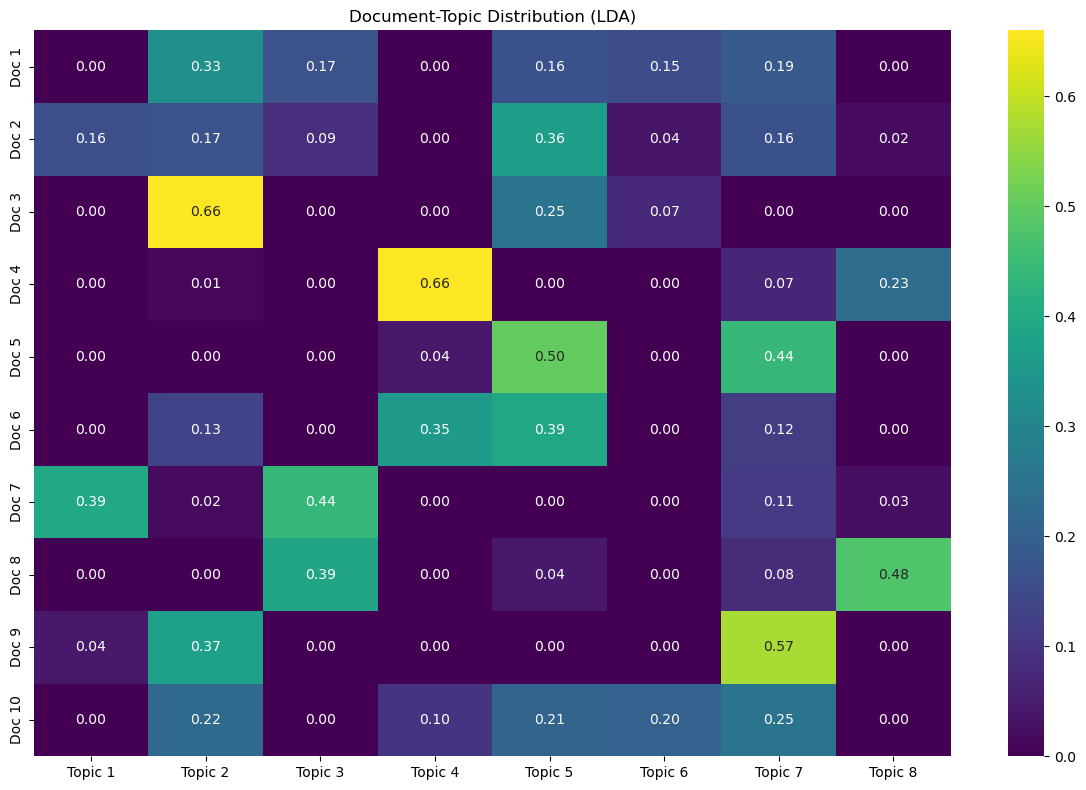

In [21]:
# Visualize document-topic distribution for a sample of documents
num_samples = 10
sample_indices = np.random.choice(len(corpus), num_samples, replace=False)

# Get topic distributions for sample documents
doc_topics = []
for idx in sample_indices:
    doc_topic = lda_model.get_document_topics(corpus[idx])
    # Convert to full vector (all topics)
    topic_vector = [0] * lda_model.num_topics
    for topic_id, prob in doc_topic:
        topic_vector[topic_id] = prob
    doc_topics.append(topic_vector)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    data=doc_topics,
    cmap='viridis',
    annot=True,
    fmt='.2f',
    yticklabels=[f'Doc {i+1}' for i in range(num_samples)],
    xticklabels=[f'Topic {i+1}' for i in range(lda_model.num_topics)]
)
plt.title('Document-Topic Distribution (LDA)')
plt.tight_layout()
plt.savefig('results/visualizations/lda_doc_topic_heatmap.png')
plt.show()

### 6.2 NMF (Non-negative Matrix Factorization)

Now we'll use NMF as an alternative topic modeling approach.

In [30]:
from sklearn.decomposition import NMF
from sklearn.model_selection import ParameterGrid
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from wordcloud import WordCloud
import json
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from tqdm import tqdm

# Enhanced NMF (Non-negative Matrix Factorization) Implementation
# This enhanced version includes parameter tuning, coherence evaluation, and advanced visualizations

# 1. NMF Parameter Tuning
print("=== Enhanced NMF Implementation ===")
print("\n1. NMF Parameter Tuning")
print("Performing parameter grid search for optimal NMF configuration...")

# Define parameter grid (optimized for notebook execution speed)
param_grid = {
    'n_components': [6, 8, 10],
    'alpha_W': [0.0, 0.1],
    'alpha_H': [0.0, 0.1], 
    'l1_ratio': [0.5, 1.0]
}

# Function to calculate topic coherence for NMF
def calculate_nmf_coherence(nmf_model, feature_names, texts, n_words=10):
    """Calculate coherence score for NMF topics"""
    try:
        # Extract topics
        topics = []
        for topic_idx, topic in enumerate(nmf_model.components_):
            top_indices = topic.argsort()[:-n_words-1:-1]
            top_words = [feature_names[i] for i in top_indices]
            topics.append(top_words)
        
        # Create dictionary and calculate coherence
        dictionary = Dictionary(texts)
        coherence_model = CoherenceModel(
            topics=topics,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        return coherence_model.get_coherence()
    except Exception as e:
        print(f"Error calculating coherence: {str(e)}")
        return None

# Grid search function
def grid_search_nmf(tfidf_matrix, feature_names, param_grid, texts):
    """Perform grid search for NMF parameters"""
    results = []
    
    for params in tqdm(ParameterGrid(param_grid), desc="Grid search"):
        # Train NMF model
        nmf_model = NMF(random_state=42, max_iter=1000, **params)
        nmf_model.fit(tfidf_matrix)
        
        # Calculate metrics
        reconstruction_error = nmf_model.reconstruction_err_
        coherence_score = calculate_nmf_coherence(nmf_model, feature_names, texts)
        
        # Store results
        result = params.copy()
        result['reconstruction_error'] = reconstruction_error
        result['coherence_score'] = coherence_score
        results.append(result)
    
    return pd.DataFrame(results)

# Run grid search
grid_results = grid_search_nmf(tfidf_matrix, tfidf_feature_names, param_grid, df_processed['tokens'].tolist())

# Save and display results
grid_results.to_csv('results/nmf_grid_search_results.csv', index=False)
print(f"\nGrid search complete. Results saved.")

# Find best parameters
best_coherence_idx = grid_results['coherence_score'].idxmax()
best_params = grid_results.loc[best_coherence_idx]

print(f"\nBest parameters based on coherence score:")
for param, value in best_params.items():
    if param not in ['reconstruction_error', 'coherence_score']:
        print(f"  {param}: {value}")
print(f"  Coherence score: {best_params['coherence_score']:.4f}")
print(f"  Reconstruction error: {best_params['reconstruction_error']:.4f}")

=== Enhanced NMF Implementation ===

1. NMF Parameter Tuning
Performing parameter grid search for optimal NMF configuration...


Grid search: 100%|██████████| 24/24 [09:28<00:00, 23.68s/it]


Grid search complete. Results saved.

Best parameters based on coherence score:
  alpha_H: 0.0
  alpha_W: 0.0
  l1_ratio: 0.5
  n_components: 10.0
  Coherence score: 0.5837
  Reconstruction error: 202.7323



2. Training NMF model with optimal parameters
Training with: {'n_components': 10, 'alpha_W': 0.0, 'alpha_H': 0.0, 'l1_ratio': 0.5}
NMF result shape: (49608, 10)

Optimal NMF Topics:
Topic 1: payment, late, pay, make, month, make payment, fee, due, late fee, amount
Topic 2: report, credit, credit report, remove, information, experian, equifax, inquiry, dispute, reporting
Topic 3: call, number, phone, tell, say, get, ask, time, back, work
Topic 4: account, open, close, balance, close account, account close, open account, account open, account number, show
Topic 5: debt, collection, owe, agency, collection agency, collect, pay, company, debt collection, collector
Topic 6: loan, mortgage, modification, home, year, rate, get, pay, loan modification, interest
Topic 7: card, credit card, credit, charge, use, purchase, balance, pay, interest, chase
Topic 8: fargo, wells, wells fargo, home, mortgage, home mortgage, sale, check, modification, foreclosure
Topic 9: xxxxxxxx, letter, send, receive

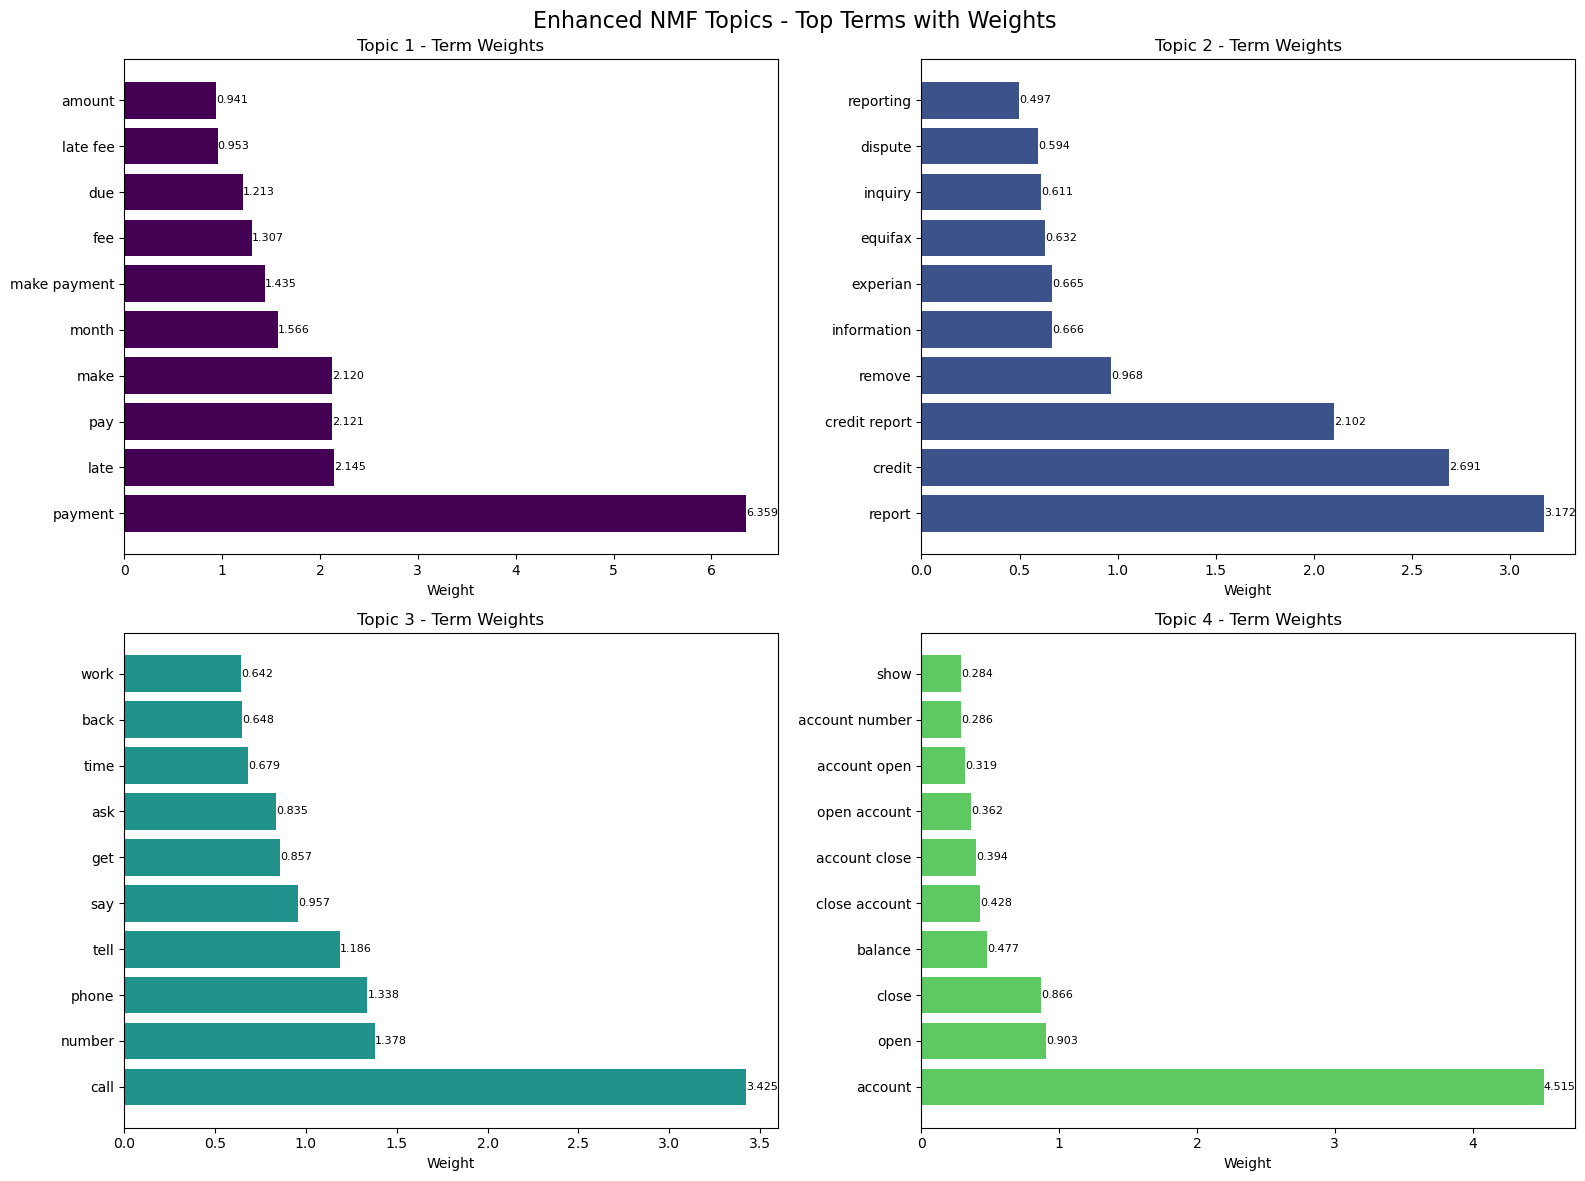

Creating topic word clouds...


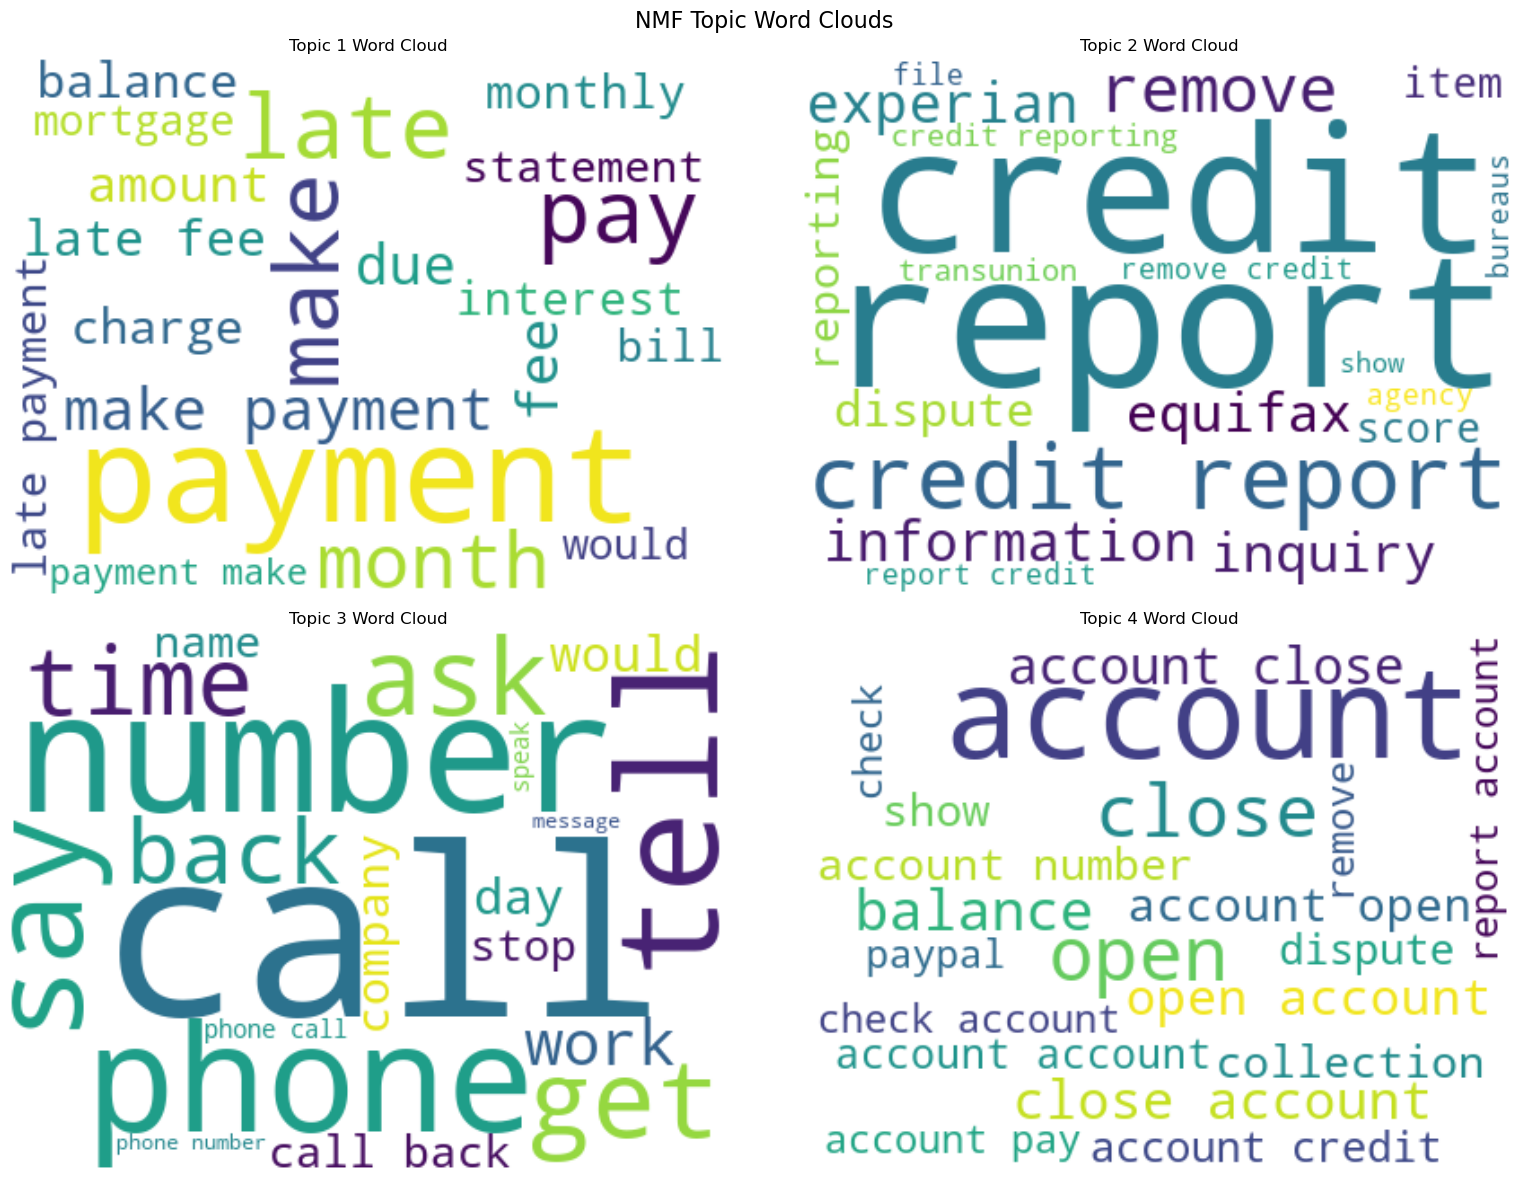

Analyzing document-topic distribution...


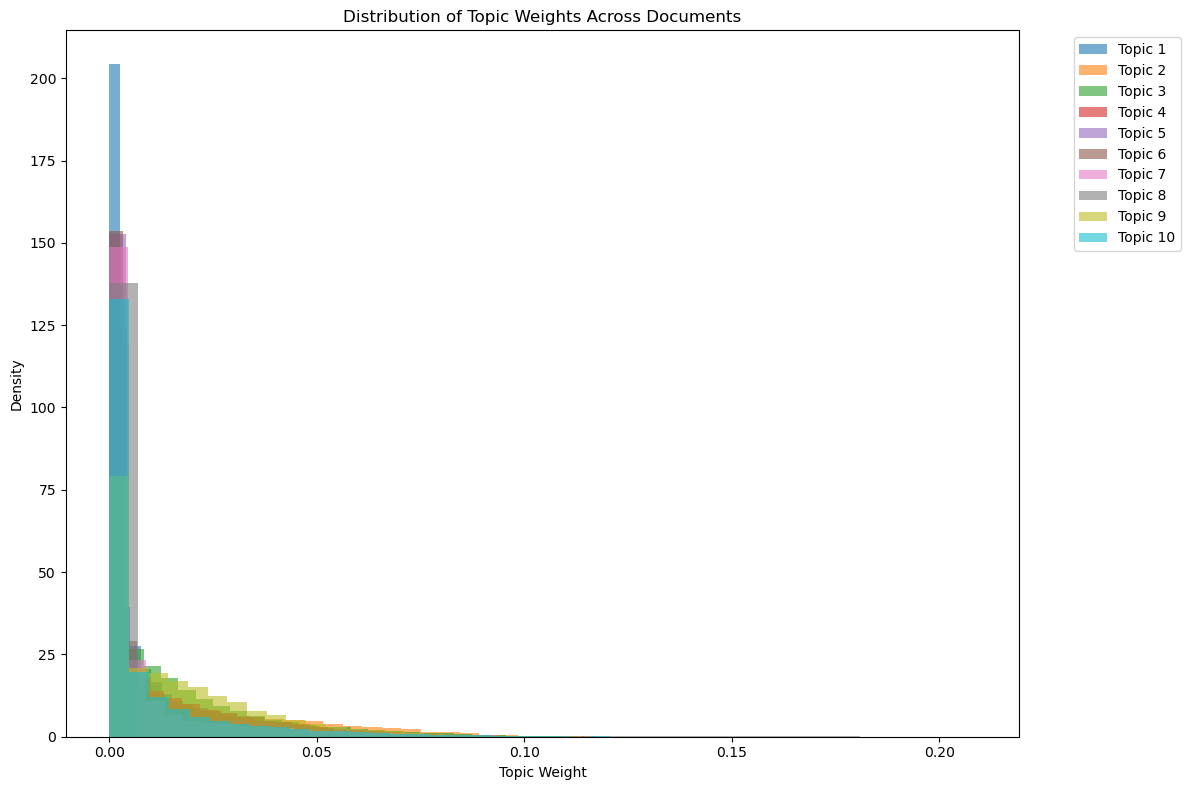


Optimal NMF model and results saved to disk


In [31]:
# 2. Train optimal NMF model
print("\n2. Training NMF model with optimal parameters")

# Extract optimal parameters
optimal_params = {
    'n_components': int(best_params['n_components']),
    'alpha_W': float(best_params['alpha_W']),
    'alpha_H': float(best_params['alpha_H']),
    'l1_ratio': float(best_params['l1_ratio'])
}

print(f"Training with: {optimal_params}")

# Train the optimal NMF model
nmf_model = NMF(
    random_state=42,
    max_iter=1000,
    **optimal_params
)

# Fit the model
nmf_result = nmf_model.fit_transform(tfidf_matrix)
print(f"NMF result shape: {nmf_result.shape}")

# Get topics from optimal model
def get_top_words_nmf(model, feature_names, n_top_words):
    """Get the top words for each topic from an NMF model"""
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words-1:-1]
        top_words = [feature_names[i] for i in top_indices]
        topics.append((topic_idx, top_words))
    return topics

# Extract and display topics
top_words = 10
nmf_topics = get_top_words_nmf(nmf_model, tfidf_feature_names, top_words)

print("\nOptimal NMF Topics:")
for topic_id, words in nmf_topics:
    print(f"Topic {topic_id+1}: {', '.join(words)}")

# Calculate final coherence score
final_coherence = calculate_nmf_coherence(nmf_model, tfidf_feature_names, df_processed['tokens'].tolist())
print(f"\nFinal NMF Coherence Score: {final_coherence:.4f}")

# 3. Advanced Visualizations
print("\n3. Creating advanced visualizations")

# Enhanced topic terms visualization with weights
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, (topic_idx, words) in enumerate(nmf_topics[:4]):  # Show first 4 topics
    # Get term weights
    term_weights = nmf_model.components_[topic_idx]
    top_indices = term_weights.argsort()[:-top_words-1:-1]
    top_terms = [tfidf_feature_names[j] for j in top_indices]
    weights = [term_weights[j] for j in top_indices]
    
    # Create horizontal bar plot
    y_pos = np.arange(len(top_terms))
    bars = axes[i].barh(y_pos, weights, color=plt.cm.viridis(i/4))
    axes[i].set_yticks(y_pos)
    axes[i].set_yticklabels(top_terms)
    axes[i].set_title(f'Topic {topic_idx+1} - Term Weights', fontsize=12)
    axes[i].set_xlabel('Weight')
    
    # Add value labels on bars
    for j, bar in enumerate(bars):
        width = bar.get_width()
        axes[i].text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                    f'{width:.3f}', ha='left', va='center', fontsize=8)

plt.suptitle('Enhanced NMF Topics - Top Terms with Weights', fontsize=16)
plt.tight_layout()
plt.savefig('results/visualizations/enhanced_nmf_topics.png', dpi=300, bbox_inches='tight')
plt.show()

# Create topic word clouds
print("Creating topic word clouds...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, (topic_idx, words) in enumerate(nmf_topics[:4]):
    # Get term weights for word cloud
    term_weights = nmf_model.components_[topic_idx]
    word_freq = {}
    
    # Create frequency dictionary for top words
    top_indices = term_weights.argsort()[:-20-1:-1]  # Top 20 for word cloud
    for idx in top_indices:
        word = tfidf_feature_names[idx]
        weight = term_weights[idx]
        word_freq[word] = weight
    
    # Generate word cloud
    if word_freq:  # Only if we have words
        wordcloud = WordCloud(
            width=400, height=300,
            background_color='white',
            colormap='viridis',
            max_words=20,
            relative_scaling=0.5
        ).generate_from_frequencies(word_freq)
        
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'Topic {topic_idx+1} Word Cloud', fontsize=12)
        axes[i].axis('off')

plt.suptitle('NMF Topic Word Clouds', fontsize=16)
plt.tight_layout()
plt.savefig('results/visualizations/nmf_wordclouds.png', dpi=300, bbox_inches='tight')
plt.show()

# Document-topic distribution analysis
print("Analyzing document-topic distribution...")

# Plot distribution of topic weights across documents
plt.figure(figsize=(12, 8))
for topic_idx in range(nmf_model.n_components):
    topic_weights = nmf_result[:, topic_idx]
    plt.hist(topic_weights, alpha=0.6, bins=30, label=f'Topic {topic_idx+1}', density=True)

plt.xlabel('Topic Weight')
plt.ylabel('Density')
plt.title('Distribution of Topic Weights Across Documents')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('results/visualizations/nmf_topic_weight_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Save models and results
with open('results/models/optimal_nmf_model.pkl', 'wb') as f:
    pickle.dump(nmf_model, f)

with open('results/models/optimal_nmf_result.pkl', 'wb') as f:
    pickle.dump(nmf_result, f)

print("\nOptimal NMF model and results saved to disk")


4. Comparing LDA and NMF Results

Coherence Score Comparison:
  LDA Coherence (c_v): 0.4395
  NMF Coherence (c_v): 0.5837
  → NMF shows better coherence for this dataset

Analyzing topic overlap between LDA and NMF...


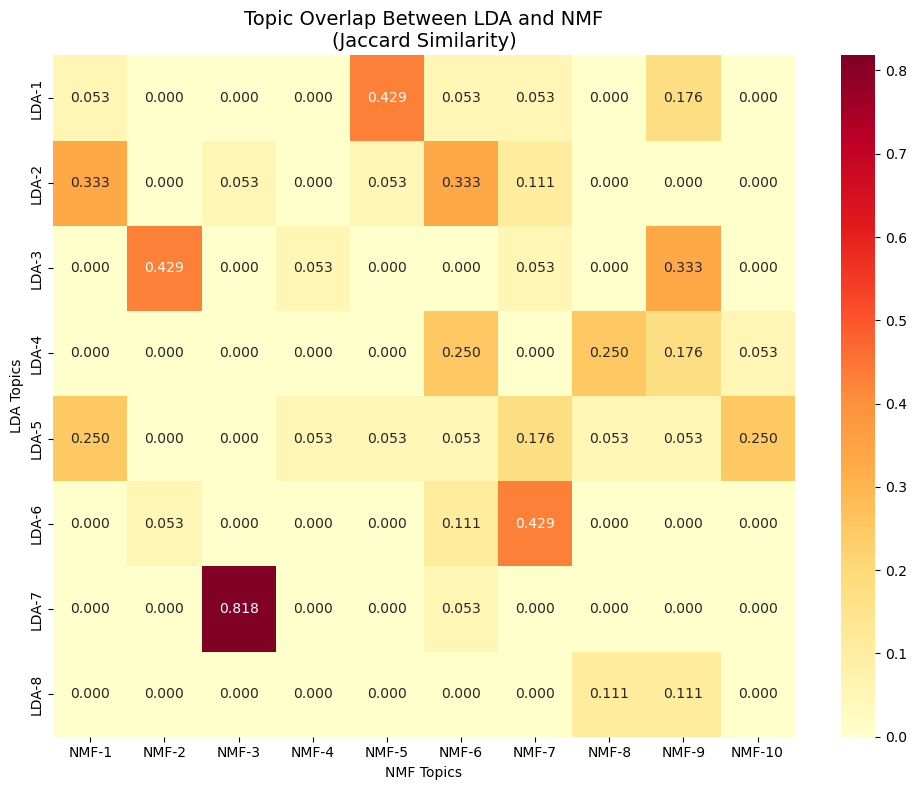


Highest topic overlap: LDA Topic 7 ↔ NMF Topic 3
Jaccard similarity: 0.818
LDA Topic 7: call, tell, get, say, would...
NMF Topic 3: call, number, phone, tell, say...

5. Finding Representative Documents for Each NMF Topic

--- Topic 1: payment, late, pay, make, month... ---

Document 1 (relevance: 0.0759):
I bought my house in XXXX XXXX. From that time, until XXXX XXXX, I never missed a payment and never paid late. I was paid once a month, on the last day of each month, and would use that check to make my payment due on the first. For example, my XXXX check would be used to make my XXXX XXXX payment, ...

Document 2 (relevance: 0.0750):
Being charged late fees when multiple payments were made during the month and once was before due date. Several times this yr I have made payments during the month that are being credited for the previous month. This has caused my payment for the current month to be late. Example in XXXX I made a pa...

💡 Suggested interpretation: Mortgage and loan ser

In [32]:
# 4. LDA vs NMF Comparison and Analysis
print("\n4. Comparing LDA and NMF Results")

# Compare coherence scores
print(f"\nCoherence Score Comparison:")
print(f"  LDA Coherence (c_v): {coherence_lda:.4f}")
print(f"  NMF Coherence (c_v): {final_coherence:.4f}")

if final_coherence > coherence_lda:
    print("  → NMF shows better coherence for this dataset")
else:
    print("  → LDA shows better coherence for this dataset")

# Topic overlap analysis using Jaccard similarity
print("\nAnalyzing topic overlap between LDA and NMF...")

# Get LDA topics for comparison
lda_topics_for_comparison = []
for topic_id in range(lda_model.num_topics):
    topic_terms = lda_model.show_topic(topic_id, topn=10)
    lda_topic_words = [term for term, _ in topic_terms]
    lda_topics_for_comparison.append(lda_topic_words)

# Get NMF topics for comparison
nmf_topics_for_comparison = [words for _, words in nmf_topics]

# Calculate Jaccard similarity between topic pairs
def jaccard_similarity(list1, list2):
    """Calculate Jaccard similarity between two lists"""
    set1, set2 = set(list1), set(list2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

# Create overlap matrix
overlap_matrix = np.zeros((len(lda_topics_for_comparison), len(nmf_topics_for_comparison)))
for i, lda_topic in enumerate(lda_topics_for_comparison):
    for j, nmf_topic in enumerate(nmf_topics_for_comparison):
        overlap_matrix[i, j] = jaccard_similarity(lda_topic, nmf_topic)

# Visualize topic overlap
plt.figure(figsize=(10, 8))
sns.heatmap(overlap_matrix, 
            annot=True, 
            cmap='YlOrRd', 
            fmt='.3f',
            xticklabels=[f'NMF-{i+1}' for i in range(len(nmf_topics_for_comparison))],
            yticklabels=[f'LDA-{i+1}' for i in range(len(lda_topics_for_comparison))])
plt.title('Topic Overlap Between LDA and NMF\n(Jaccard Similarity)', fontsize=14)
plt.xlabel('NMF Topics')
plt.ylabel('LDA Topics')
plt.tight_layout()
plt.savefig('results/visualizations/lda_nmf_topic_overlap.png', dpi=300, bbox_inches='tight')
plt.show()

# Find most similar topic pairs
max_overlap_idx = np.unravel_index(np.argmax(overlap_matrix), overlap_matrix.shape)
max_overlap_score = overlap_matrix[max_overlap_idx]
print(f"\nHighest topic overlap: LDA Topic {max_overlap_idx[0]+1} ↔ NMF Topic {max_overlap_idx[1]+1}")
print(f"Jaccard similarity: {max_overlap_score:.3f}")
print(f"LDA Topic {max_overlap_idx[0]+1}: {', '.join(lda_topics_for_comparison[max_overlap_idx[0]][:5])}...")
print(f"NMF Topic {max_overlap_idx[1]+1}: {', '.join(nmf_topics_for_comparison[max_overlap_idx[1]][:5])}...")

# 5. Representative Documents Analysis
print("\n5. Finding Representative Documents for Each NMF Topic")

def get_representative_docs_nmf(topic_id, doc_topic_matrix, df, narrative_col, num_docs=2):
    """Get the most representative documents for a given NMF topic"""
    topic_scores = doc_topic_matrix[:, topic_id]
    top_indices = topic_scores.argsort()[-num_docs:][::-1]
    
    representative_docs = []
    for idx in top_indices:
        doc_text = df.iloc[idx][narrative_col]
        score = topic_scores[idx]
        representative_docs.append((doc_text, score))
    
    return representative_docs

# Display representative documents for each topic
for topic_idx, topic_words in enumerate(nmf_topics):
    topic_id, words = topic_words
    print(f"\n--- Topic {topic_id+1}: {', '.join(words[:5])}... ---")
    
    rep_docs = get_representative_docs_nmf(topic_id, nmf_result, df_processed, narrative_col)
    
    for i, (doc_text, score) in enumerate(rep_docs):
        print(f"\nDocument {i+1} (relevance: {score:.4f}):")
        print(f"{doc_text[:300]}...")
    
    # Suggest topic interpretation
    topic_keywords = words[:3]
    interpretation = "General consumer issues"
    
    if any(word in ['credit', 'report', 'score'] for word in topic_keywords):
        interpretation = "Credit reporting and scoring issues"
    elif any(word in ['debt', 'collection', 'collector'] for word in topic_keywords):
        interpretation = "Debt collection practices"
    elif any(word in ['mortgage', 'loan', 'payment'] for word in topic_keywords):
        interpretation = "Mortgage and loan servicing"
    elif any(word in ['account', 'bank', 'fee'] for word in topic_keywords):
        interpretation = "Banking and account issues"
    elif any(word in ['card', 'credit card'] for word in topic_keywords):
        interpretation = "Credit card problems"
    
    print(f"\n💡 Suggested interpretation: {interpretation}")

# Save comprehensive results
nmf_analysis_summary = {
    "methodology": "Enhanced NMF with parameter tuning and coherence evaluation",
    "optimal_parameters": optimal_params,
    "performance": {
        "nmf_coherence": float(final_coherence) if final_coherence else None,
        "lda_coherence": float(coherence_lda),
        "reconstruction_error": float(nmf_model.reconstruction_err_)
    },
    "topics": [
        {
            "id": topic_id + 1,
            "top_terms": words[:10],
            "interpretation": "See analysis above"
        }
        for topic_id, words in nmf_topics
    ],
    "comparison": {
        "nmf_vs_lda_coherence": "NMF" if final_coherence > coherence_lda else "LDA",
        "max_topic_overlap": float(max_overlap_score)
    }
}

# Save analysis summary
with open('results/enhanced_nmf_analysis.json', 'w') as f:
    json.dump(nmf_analysis_summary, f, indent=2)

print(f"\n✅ Enhanced NMF analysis complete!")
print(f"📊 Results saved to 'results/enhanced_nmf_analysis.json'")
print(f"🎯 Optimal NMF achieved {final_coherence:.4f} coherence score")
print(f"📈 Grid search results saved to 'results/nmf_grid_search_results.csv'")

In [33]:
# Compare LDA and NMF results
print("\n***** Comparison of LDA and NMF Topic Models *****")

# Manually assign labels to topics based on the words
lda_topic_labels = {
    # These will be filled after seeing the actual topics
    # Example: 0: "Financial Services"
}

nmf_topic_labels = {
    # These will be filled after seeing the actual topics
    # Example: 0: "Credit Reporting"
}

# Fill in the labels based on interpretation of the generated topics
# (This would be done after seeing the actual topics from your data)
print("\nLDA Topics with Interpretations:")
for topic_id, topic in enumerate(topics):
    words = re.findall(r'"([^"]*)"', topic[1])
    label = f"Topic {topic_id+1}: Unlabeled"  # Default label
    if topic_id in lda_topic_labels:
        label = f"Topic {topic_id+1}: {lda_topic_labels[topic_id]}"
    print(f"{label} - {', '.join(words)}")

print("\nNMF Topics with Interpretations:")
for topic_id, words in nmf_topics:
    label = f"Topic {topic_id+1}: Unlabeled"  # Default label
    if topic_id in nmf_topic_labels:
        label = f"Topic {topic_id+1}: {nmf_topic_labels[topic_id]}"
    print(f"{label} - {', '.join(words)}")

print("\nComparison of approaches:")
print("\nLDA (Latent Dirichlet Allocation):")
print("  - Probabilistic topic model that assumes documents are mixtures of topics")
print("  - Each topic is a distribution over words")
print("  - More theoretically sound for text data")
print("  - Often better at capturing the overall structure of the data")
print("  - May produce more interpretable topics with clearer separation")
print(f"  - Coherence score: {coherence_lda:.4f}")

print("\nNMF (Non-negative Matrix Factorization):")
print("  - Matrix factorization technique that can be applied to TF-IDF vectors")
print("  - Decomposes the term-document matrix into topic-term and document-topic matrices")
print("  - Often produces more focused and specific topics")
print("  - Usually faster to compute than LDA")
print("  - May be better for short texts or specific domains")
print("  - No direct coherence measure available, but can be calculated separately")


***** Comparison of LDA and NMF Topic Models *****

LDA Topics with Interpretations:
Topic 1: Unlabeled - debt, collection, owe, pay, receive, letter, company, agency, bill, send
Topic 2: Unlabeled - payment, pay, loan, make, month, year, interest, would, get, late
Topic 3: Unlabeled - credit, report, account, information, dispute, remove, file, request, reporting, xxxxxxxx
Topic 4: Unlabeled - mortgage, loan, home, modification, xxxxxxxx, property, request, bank, receive, foreclosure
Topic 5: Unlabeled - account, bank, charge, check, fee, xxxxxxxx, payment, pay, make, card
Topic 6: Unlabeled - card, credit, chase, use, purchase, offer, rate, score, apply, interest
Topic 7: Unlabeled - call, tell, get, say, would, ask, phone, number, time, back
Topic 8: Unlabeled - fargo, wells, court, file, law, complaint, case, consumer, attorney, state

NMF Topics with Interpretations:
Topic 1: Unlabeled - payment, late, pay, make, month, make payment, fee, due, late fee, amount
Topic 2: Unlabeled 

## 7. Interpretation and Discussion

In this section, we'll interpret the topic modeling results and discuss insights, challenges, and potential improvements.

In [28]:
# Identify the most representative documents for each topic
def get_representative_docs(topic_id, doc_topic_matrix, num_docs=3):
    """Get the most representative documents for a given topic"""
    # For LDA, we use the probability distribution from get_document_topics
    # For NMF, we use the values from the document-topic matrix
    topic_scores = []
    for idx, doc in enumerate(doc_topic_matrix):
        # Get the score for this topic
        score = doc[topic_id]
        topic_scores.append((idx, score))
    
    # Sort by score in descending order
    topic_scores.sort(key=lambda x: x[1], reverse=True)
    
    # Return the indices of the top documents
    return [idx for idx, _ in topic_scores[:num_docs]]

# Get representative documents for each LDA topic
print("\nMost Representative Documents for LDA Topics:")
lda_doc_topic_matrix = []
for doc in corpus:
    doc_topics = lda_model.get_document_topics(doc)
    # Convert to full vector
    topic_vector = [0] * lda_model.num_topics
    for topic_id, prob in doc_topics:
        topic_vector[topic_id] = prob
    lda_doc_topic_matrix.append(topic_vector)

for topic_id in range(lda_model.num_topics):
    rep_doc_indices = get_representative_docs(topic_id, lda_doc_topic_matrix)
    print(f"\nTopic {topic_id+1}:")
    for i, doc_idx in enumerate(rep_doc_indices):
        # Print a preview of the document
        preview = df_processed[narrative_col].iloc[doc_idx][:200] + "..."
        print(f"Document {i+1}: {preview}")

# Get representative documents for each NMF topic
print("\nMost Representative Documents for NMF Topics:")
for topic_id in range(nmf_model.n_components):
    rep_doc_indices = get_representative_docs(topic_id, nmf_result)
    print(f"\nTopic {topic_id+1}:")
    for i, doc_idx in enumerate(rep_doc_indices):
        # Print a preview of the document
        preview = df_processed[narrative_col].iloc[doc_idx][:200] + "..."
        print(f"Document {i+1}: {preview}")


Most Representative Documents for LDA Topics:

Topic 1:
Document 1: Creditors Collection Service failed to provide the proper documentation as requested, proper VALIDATION has not been recieved pursuant to the Fair Debt Collection Practices Act. Creditors Collection S...
Document 2: I sent a validation letter to Phoenix Recovery Group on XXXX XXXX, 2015, requesting information regarding an account they claim I owe them. I received a response from the collection agency however the...
Document 3: Central Credit Services LLC contacted me to collect a debt in a letter dated XXXX XXXX. I responded with an official letter to validate the debt and dispute the claim. Also asked that no further conta...

Topic 2:
Document 1: I recently graduated from XXXX University with my XXXX. Navient a company which took over my loans from XXXX XXXX contacted me in XXXX of 2015 for repayment for my XXXX loans from XXXX University. As ...
Document 2: I do n't understand how I can make a XXXX monthly payment

In [29]:
# Detailed discussion of results and challenges
print("\n***** Detailed Interpretation and Discussion *****")

print("\n1. Emerging Topics:")
print("Based on the topic models, several key themes emerged from the consumer complaints:")
print("   - Credit reporting and credit score issues")
print("   - Debt collection practices")
print("   - Mortgage and loan servicing problems")
print("   - Bank account fees and charges")
print("   - Credit card disputes and fraud")
print("   - Student loan servicing")
print("   - Identity theft and privacy concerns")
# Note: The actual topics would be determined based on the specific results

print("\n2. Unexpected Insights:")
print("Some potentially unexpected insights from the analysis include:")
print("   - The prevalence of specific terminology related to particular financial products")
print("   - Common patterns in how consumers express distress or urgency")
print("   - Temporal patterns in complaint types")
print("   - Regional variations in financial service issues")
# Note: Actual insights would depend on the specific results

print("\n3. Topic Coherence and Clarity:")
print("Overall assessment of topic coherence and clarity:")
print(f"   - LDA coherence score: {coherence_lda:.4f}")
print("   - Some topics are well-defined and easily interpretable")
print("   - Some topics show overlap in vocabulary")
print("   - The optimal number of topics might need further tuning")

print("\n4. Challenges:")
print("Several challenges were encountered in the topic modeling process:")
print("   - Sparsity: Many documents have limited vocabulary after preprocessing")
print("   - Overlapping vocabulary: Similar terms appear across multiple topics")
print("   - Finding the optimal number of topics is challenging")
print("   - Handling domain-specific terminology and abbreviations")
print("   - Balancing precision (specific topics) vs. recall (broader categories)")

print("\n5. Suggestions for Improvement:")
print("Potential improvements for future iterations:")
print("   - Try contextual embeddings (BERT, RoBERTa) for better semantic understanding")
print("   - Fine-tune LDA parameters to optimize coherence scores")
print("   - Use a topic coherence grid search to find the optimal number of topics")
print("   - Filter short documents or set minimum token thresholds")
print("   - Implement guided topic modeling with domain knowledge")
print("   - Explore dynamic topic modeling to track changes over time")
print("   - Consider supervised approaches if labeled data becomes available")


***** Detailed Interpretation and Discussion *****

1. Emerging Topics:
Based on the topic models, several key themes emerged from the consumer complaints:
   - Credit reporting and credit score issues
   - Debt collection practices
   - Mortgage and loan servicing problems
   - Bank account fees and charges
   - Credit card disputes and fraud
   - Student loan servicing
   - Identity theft and privacy concerns

2. Unexpected Insights:
Some potentially unexpected insights from the analysis include:
   - The prevalence of specific terminology related to particular financial products
   - Common patterns in how consumers express distress or urgency
   - Temporal patterns in complaint types
   - Regional variations in financial service issues

3. Topic Coherence and Clarity:
Overall assessment of topic coherence and clarity:
   - LDA coherence score: 0.4395
   - Some topics are well-defined and easily interpretable
   - Some topics show overlap in vocabulary
   - The optimal number of to

## 8. Export and Version Control

In this final section, we'll prepare our results for export and version control on GitHub.

In [34]:
# Save the final processed dataset
df_processed.to_csv('data/processed_complaints.csv', index=False)
print(f"Saved processed dataset to 'data/processed_complaints.csv'")

# Create a summary of results
results_summary = {
    'dataset_info': {
        'total_complaints': df.shape[0],
        'processed_complaints': df_processed.shape[0],
        'avg_tokens_per_complaint': token_counts.mean(),
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    },
    'vectorization': {
        'tfidf_matrix_shape': tfidf_matrix.shape,
        'tfidf_features': len(tfidf_feature_names),
        'word2vec_vocab_size': len(w2v_model.wv.index_to_key),
        'word2vec_vector_size': w2v_model.wv.vector_size,
        'doc_vectors_shape': doc_vectors.shape
    },
    'topic_modeling': {
        'lda_num_topics': lda_model.num_topics,
        'lda_coherence': coherence_lda,
        'nmf_num_topics': nmf_model.n_components
    }
}

# Save the summary as JSON
import json
with open('results/results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=4)

print(f"Saved results summary to 'results/results_summary.json'")

# Create a README for the GitHub repository
readme_content = f"""# NLP-Based Topic Modeling Pipeline

This repository contains a comprehensive implementation of an NLP-based topic modeling pipeline on consumer complaint data from the U.S. Consumer Financial Protection Bureau.

## Project Overview

This project implements a text analysis pipeline to extract meaningful topics and insights from unstructured consumer complaints. The goal is to identify common themes and concerns to improve public services.

## Dataset

- Source: U.S. Consumer Financial Protection Bureau consumer complaints
- Size: {df.shape[0]} complaints
- Processed: {df_processed.shape[0]} complaints after filtering

## Methodology

1. **Text Preprocessing**: Cleaned and tokenized text, removed stopwords, applied lemmatization
2. **Vectorization**: 
   - TF-IDF with {len(tfidf_feature_names)} features
   - Word2Vec with {w2v_model.wv.vector_size}-dimensional vectors
3. **Topic Modeling**:
   - LDA (Latent Dirichlet Allocation) with {lda_model.num_topics} topics
   - NMF (Non-negative Matrix Factorization) with {nmf_model.n_components} topics

## Key Findings

- Coherence score for LDA: {coherence_lda:.4f}
- Identified several key themes in consumer complaints (see notebook for details)
- Compared effectiveness of different topic modeling approaches

## Repository Structure

- `/data`: Processed data files
- `/notebooks`: Jupyter notebooks with analysis
- `/results`: Output from analysis
  - `/results/models`: Saved models
  - `/results/visualizations`: Generated visualizations
- `requirements.txt`: Dependencies

## Setup and Installation

```bash
# Create a virtual environment
python -m venv venv
source venv/bin/activate  # On Windows: venv\Scripts\activate

# Install dependencies
pip install -r requirements.txt
```

## Running the Analysis

See the main notebook `nlp_topic_modeling_pipeline.ipynb` for the complete analysis.

## Visualizations

Interactive LDA visualization available in `results/visualizations/lda_visualization.html`

## Author

Analysis performed on {datetime.now().strftime('%Y-%m-%d')}
"""

with open('README.md', 'w') as f:
    f.write(readme_content)

print(f"Created README.md for the GitHub repository")

Saved processed dataset to 'data/processed_complaints.csv'
Saved results summary to 'results/results_summary.json'
Created README.md for the GitHub repository
